In [0]:
import pdb
import matplotlib.pyplot as plt
import sys
import numpy as np
import pickle
import copy
import os
from PIL import Image

import tensorflow as tf
config = tf.ConfigProto()
#config.gpu_options.allow_growth = True
config.gpu_options.per_process_gpu_memory_fraction = 0.3
session = tf.Session(config=config)

from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, BatchNormalization, Activation, ZeroPadding2D, MaxPooling2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D, Conv2DTranspose
from keras.models import Sequential, Model, load_model
from keras.optimizers import Adam
from keras import backend as K
from keras.backend.tensorflow_backend import set_session


In [2]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
class GAN():
    def __init__(self,dataset_name='',load_model_name=''):
        
        optimizer = Adam(0.0002, 0.5)
        
        if (load_model_name == ''):
            #X_train = self.load_gan_data(dataset_name)
            
            #print("Loading dataset...")
            
            ndata = 200
            patch_size = 128
            self.patch_size = patch_size
            
            self.X_tr = np.zeros((ndata, patch_size, patch_size, 3))
            
            for i in range(ndata):
              #if(i%10==0):
                #print("Image ",i+1)
              im = Image.open("drive/My Drive/texture/patchset1/patchno"+str(i)+".jpg")
              self.X_tr[i,:,:,:] = np.array(im)/255
            
            print("Dataset loaded.")
            
            # default parameters for mnist 
            self.img_rows = self.X_tr.shape[1]
            self.img_cols = self.X_tr.shape[2]
            self.img_channels = self.X_tr.shape[3]
            self.img_shape = (self.img_rows, self.img_cols, self.img_channels)
            self.z_width = 4
            self.z_height = 4
            self.z_depth = 16
            self.batch_size = 16
            self.iter_count = 0
            self.dataset_name = dataset_name
            self.model_file = 'models/'+self.dataset_name+'_gan_model.pickle'#

            # Build and compile the discriminator and discriminator loss
            self.discriminator = self.build_discriminator()
            # set discriminator loss
            # BEGIN INSERT CODE
            self.discriminator.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
            # END INSERT CODE

            # Build the generator
            self.generator = self.build_generator()

        else:
            #load gan class and models (generator, discriminator and stacked model)
            self.load_gan_model(load_model_name)

        # Create the stacked model
        #first, create the random vector z in the latent space
        z = Input(shape=(self.z_depth,self.z_depth,self.z_depth))
        #z = Input(shape=(self.z_dim,))
        #create generated (fake) image
        img = self.generator(z)

        #indicate that for the stacked model, the weights are not trained
        self.discriminator.trainable = False

        # The discriminator takes generated images as input and gives a probability of whether it is a true or
        #false image
        print("img : ", img.shape)
        p_true = self.discriminator(img)

        # The combined model  (stacked generator and discriminator)
        # In this model, we train the generator only
        self.stacked_gen_disc = Model(z, p_true)

        # loss
        # START INSERT CODE HERE
        generator_loss = K.mean(K.log(1 - p_true))
        # END INSERT CODE HERE
        self.stacked_gen_disc.add_loss(generator_loss)
        self.stacked_gen_disc.compile(optimizer=optimizer)


    def build_generator(self):

        model = Sequential()

        model.add(Conv2D(3, kernel_size=5, input_shape=(self.z_depth,self.z_depth,self.z_depth), padding="same"))
        model.add(BatchNormalization(momentum=0.9))
        model.add(Activation("relu"))
        model.add(UpSampling2D())
        model.add(Conv2D(128, kernel_size=3, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation("relu"))
        model.add(UpSampling2D())
        model.add(Conv2D(64, kernel_size=3, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation("relu"))
        model.add(UpSampling2D())
        model.add(Conv2D(self.img_channels, kernel_size=3, padding="same"))
        model.add(Activation("tanh"))

        #model.summary()

        noise = Input(shape=(self.z_depth,self.z_depth,self.z_depth))
        img = model(noise)

        return Model(noise, img)

    def build_discriminator(self):

        model = Sequential()
        
        model.add(Conv2D(64, kernel_size=5, strides=2, input_shape=self.img_shape, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        #model.add(Dropout(0.25))
        model.add(Conv2D(128, kernel_size=5, strides=2, padding="same"))
        #model.add(ZeroPadding2D(padding=((0,1),(0,1))))
        model.add(BatchNormalization(momentum=0.9))
        model.add(LeakyReLU(alpha=0.2))
        #model.add(Dropout(0.25))
        model.add(Conv2D(256, kernel_size=5, strides=2, padding="same"))
        model.add(BatchNormalization(momentum=0.9))
        model.add(LeakyReLU(alpha=0.2))
        #model.add(Dropout(0.25))
        model.add(Conv2D(512, kernel_size=5, strides=2, padding="same"))
        model.add(BatchNormalization(momentum=0.9))
        model.add(LeakyReLU(alpha=0.2))
        #model.add(Dropout(0.25))
        model.add(Conv2D(1, kernel_size=5, strides=2, padding="same"))
        model.add(Activation('sigmoid'))

        #model.summary()

        img = Input(shape=self.img_shape)
        validity = model(img)

        return Model(img, validity)

    def load_gan_data(self,dataset_name):
        # Load the dataset
        if(dataset_name == 'mnist'):
            (X_train, _), (_, _) = mnist.load_data()
        elif(dataset_name == 'cifar'):
            from keras.datasets import cifar10
            (X_train, y_train), (X_test, y_test) = cifar10.load_data()
        else:
            print('Error, unknown database')

        # Rescale -1 to 1
        X_train = X_train / 127.5 - 1.
        #add a channel dimension, if need be (for mnist data)
        if(X_train.ndim ==3):
            X_train = np.expand_dims(X_train, axis=3)
        return X_train

    def save_gan_model(self, model_file):

        #save the GAN class instance
        gan_temp = GAN(self.dataset_name,'')
        gan_temp.generator = self.generator
        gan_temp.discriminator = self.discriminator
        gan_temp.stacked_gen_disc = []
        gan_temp.iter_count = self.iter_count
        with open(model_file,'wb') as file_class:
            pickle.dump(gan_temp,file_class,-1)

    def load_gan_model(self, model_file):

        #load GAN class instance
        gan_temp = pickle.load(open(model_file,"rb",-1))
        #copy parameters
        self.img_rows = gan_temp.img_rows 
        self.img_cols = gan_temp.img_cols 
        self.img_channels = gan_temp.img_channels 
        self.img_shape = gan_temp.img_shape
        self.z_dim = gan_temp.z_dim
        self.iter_count = gan_temp.iter_count
        self.model_file = gan_temp.model_file
        self.dataset_name = gan_temp.dataset_name

        #copy models
        self.generator = gan_temp.generator
        self.discriminator = gan_temp.discriminator

    def train(self, epochs, batch_size=128, sample_interval=50):
        
        k=1    #number of internal loops

        #load dataset
        X_train = self.X_tr
        # Adversarial ground truths
        d_output_true = np.ones((batch_size, self.z_width, self.z_height, 1))-0.3*np.random.rand(batch_size, self.z_width, self.z_height, 1)
        d_output_false = np.zeros((batch_size, self.z_width, self.z_height, 1))+0.25*np.random.rand(batch_size, self.z_width, self.z_height, 1)
        d_output_true2 = np.ones((batch_size, self.z_width, self.z_height, 1))
        d_output_false2 = np.zeros((batch_size, self.z_width, self.z_height, 1))

        first_iter =self.iter_count

        for epoch in range(first_iter,epochs):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            # Train the discriminator
            for i in range(0,k):
                # Select a random batch of images
                idx = np.random.randint(0, X_train.shape[0], batch_size)
                imgs = X_train[idx]

                z_random = np.random.normal(0, 1, (batch_size, self.z_depth, self.z_depth, self.z_depth))

                # Generate a batch of new (fake) images
                gen_imgs = self.generator.predict(z_random)
                
                # START INSERT CODE
                d_loss_real = self.discriminator.train_on_batch(imgs, d_output_true)
                d_loss_fake = self.discriminator.train_on_batch(gen_imgs, d_output_false)
                d_loss_real2 = np.mean(self.discriminator.predict(imgs))
                d_loss_fake2 = 1-np.mean(self.discriminator.predict(gen_imgs))
                # END INSERT CODE
                d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
                d_loss2 = 0.5*(d_loss_real2 + d_loss_fake2)

        
            
            # ---------------------
            #  Train Generator
            # ---------------------

            # Select a random batch of images
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs = X_train[idx]

            z_random = np.random.normal(0, 1, (batch_size, self.z_depth, self.z_depth,self.z_depth))

            # Generate a batch of new (fake) images
            gen_imgs = self.generator.predict(z_random)
            # Generator training : try to make generated images be classified as true by the discriminator
            g_loss = self.stacked_gen_disc.train_on_batch(z_random,None)

            # increase epoch counter
            self.iter_count = self.iter_count+1
            # Plot the losses
            print("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss2, g_loss))

            # Save some random generated images and the models at every sample_interval iterations
            if (epoch % 10 == 0):
                self.sample_images('images/'+self.dataset_name+'_sample_%06d.png' % epoch)
                #self.save_gan_model(self.model_file)

    def sample_images(self, image_filename, rand_seed=30):
        np.random.seed(rand_seed)

        r, c = 2, 2
        z_random = np.random.normal(0, 1, (r * c, self.z_depth, self.z_depth, self.z_depth))
        gen_imgs = self.generator.predict(z_random)

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                #black and white images
                if(gen_imgs.shape[3] == 1):
                    axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
                elif(gen_imgs.shape[3] == 3):   #colour images
                    axs[i,j].imshow(gen_imgs[cnt, :,:], vmin=0, vmax=1)
                else:
                    print('Error, unsupported channel size. Dude, I don''t know what you want me to do.\
                            I can''t handle this data. You''ve made me very sad ...')
                axs[i,j].axis('off')
                cnt += 1
        fig.savefig(image_filename)
        plt.close()

In [21]:

if __name__ == '__main__':

    #create the output image and model directories
    if (os.path.isdir('images')==0):
        os.mkdir('images')
    if (os.path.isdir('models')==0):
        os.mkdir('models')

    #choose dataset
    dataset_name = 'mnist'#

    #create GAN model
    set_session(session)

    #create GAN model
    model_file = '_gan_model.pickle'
    gan = GAN()#,
    is_training = 1

    if (is_training ==1):
        gan.train(epochs=100, batch_size=32, sample_interval=64)
    else:
        gan.sample_images('images/test_images.png')

Dataset loaded.
img :  (?, 128, 128, 3)


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [D loss: 0.946702, acc.: 50.37%] [G loss: -0.635409]
Dataset loaded.
img :  (?, 128, 128, 3)
1 [D loss: 0.794715, acc.: 50.85%] [G loss: -0.180114]
2 [D loss: 0.591364, acc.: 52.40%] [G loss: -0.132091]
3 [D loss: 0.590899, acc.: 50.53%] [G loss: -0.150732]
4 [D loss: 0.550818, acc.: 52.35%] [G loss: -0.195277]
5 [D loss: 0.507792, acc.: 51.40%] [G loss: -0.132570]
6 [D loss: 0.451640, acc.: 50.87%] [G loss: -0.159070]
7 [D loss: 0.452132, acc.: 50.56%] [G loss: -0.160745]
8 [D loss: 0.433737, acc.: 50.97%] [G loss: -0.212941]
9 [D loss: 0.438653, acc.: 50.12%] [G loss: -0.166559]
10 [D loss: 0.427764, acc.: 50.75%] [G loss: -0.222806]
Dataset loaded.
img :  (?, 128, 128, 3)
11 [D loss: 0.432653, acc.: 50.15%] [G loss: -0.179186]
12 [D loss: 0.435689, acc.: 50.10%] [G loss: -0.143552]
13 [D loss: 0.442650, acc.: 50.63%] [G loss: -0.142919]
14 [D loss: 0.436997, acc.: 50.20%] [G loss: -0.142929]
15 [D loss: 0.417308, acc.: 50.67%] [G loss: -0.162583]
16 [D loss: 0.414491, acc.: 50.26%

KeyboardInterrupt: ignored

In [0]:
gan.sample_images('images/test_images2_12.png')

In [0]:
im = Image.open("drive/My Drive/texture/patchset3/patchno"+str(0)+".jpg")

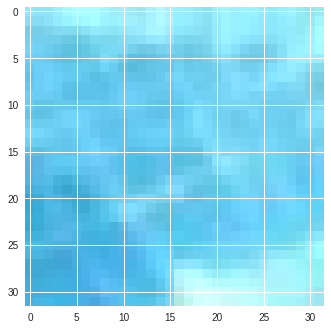

In [0]:
import matplotlib.pyplot as plt

plt.imshow(im)

In [0]:
np.array(im).shape

(32, 32, 3)

In [0]:
np.max(im)

255